<a href="https://colab.research.google.com/github/tuyenta/sketcher/blob/master/Sketcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'

--2019-05-31 19:57:33--  https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760 [text/plain]
Saving to: ‘mini_classes.txt’

mini_classes.txt    100%[===================>]     760  --.-KB/s    in 0s      

2019-05-31 19:57:38 (61.5 MB/s) - ‘mini_classes.txt’ saved [760/760]



In [0]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()
classes = [c.replace('\n','').replace(' ','_') for c in classes]

In [0]:
!mkdir data

In [0]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [0]:
download()

# Imports packages

In [0]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the data

In [0]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [0]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [4]:
print(x_train.shape)
print(len(x_test), len(y_test))

(320000, 784)
80000 80000


airplane


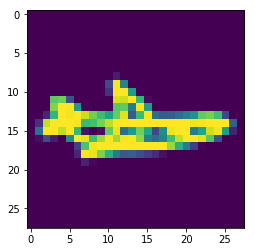

In [5]:
import matplotlib.pyplot as plt
from random import randint

%matplotlib inline
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28))
print(class_names[int(y_train[idx].item())])

# Preprocess the data

In [6]:
# Reshape and nomalize

x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test  = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test  /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)

print(len(x_test), len(y_test))

80000 80000


# Define the model

In [7]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(100, activation='softmax')) 

# Train model
adam = tf.train.AdamOptimizer()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flat

# Training

In [8]:
model.fit(x = x_train, y = y_train, validation_split=0.1,
          batch_size = 256, verbose=2, epochs=5)

Train on 288000 samples, validate on 32000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 - 243s - loss: 1.9668 - top_k_categorical_accuracy: 0.7750 - val_loss: 1.4062 - val_top_k_categorical_accuracy: 0.8744
Epoch 2/5
 - 242s - loss: 1.2599 - top_k_categorical_accuracy: 0.8915 - val_loss: 1.1669 - val_top_k_categorical_accuracy: 0.9024
Epoch 3/5
 - 242s - loss: 1.0948 - top_k_categorical_accuracy: 0.9092 - val_loss: 1.0542 - val_top_k_categorical_accuracy: 0.9135
Epoch 4/5
 - 243s - loss: 1.0028 - top_k_categorical_accuracy: 0.9192 - val_loss: 1.0202 - val_top_k_categorical_accuracy: 0.9183
Epoch 5/5
 - 241s - loss: 0.9426 - top_k_categorical_accuracy: 0.9248 - val_loss: 0.9560 - val_top_k_categorical_accuracy: 0.9217


# Testing

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 92.27%


# Inference

['sword', 'knife', 'dumbbell', 'chair', 'hat']


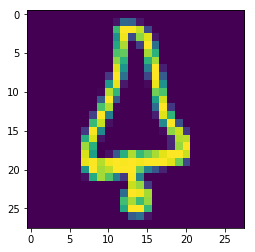

In [11]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline

idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze())
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

# Store the classes

In [0]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

In [0]:
Install TensorFlowJS

In [13]:
!pip install tensorflowjs

     |████████████████████████████████| 13.9MB 8.2MB/s 
     |████████████████████████████████| 88.1MB 256kB/s 
     |████████████████████████████████| 81kB 27.4MB/s 
     |████████████████████████████████| 440kB 45.7MB/s 
     |████████████████████████████████| 3.1MB 27.9MB/s 
     |████████████████████████████████| 61kB 24.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/89/67/41/63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
Successfully built wrapt
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
ERROR: s3fs 0.2.1 has requirement six>=1.12.0, but you'll have six 1.11.0 which is incompatible.
ERROR: jupyter-console 6.0.0 has requirement prompt-toolkit<2.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.16 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.11.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3

# Save and Convert

In [0]:
model.save('keras.h5')
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

# Zip and Download

In [17]:
!cp class_names.txt model/class_names.txt

!zip -r model.zip model

from google.colab import files
files.download('model.zip')

  adding: model/ (stored 0%)
  adding: model/class_names.txt (deflated 42%)
  adding: model/group1-shard1of1.bin (deflated 7%)
  adding: model/model.json (deflated 85%)
